# test saved data

In [3]:
%load_ext autoreload
%autoreload 2
from imports.data import *
from imports.params import p
from imports.utility import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
p["channel"] = "2chan"

sw_path = "flamingo_0077/flamingo_0077.hdf5"
data = Data(p, sw_path=sw_path)
filename = p_to_filename(p) + "_test"
data.make_obs_dataset(filename=filename, target="TotalMass")

KeyError: 'channel'

In [4]:
# data.create_obs_data(save_loc=p["base_data_path"], nr_samples=2)

FileNotFoundError: [Errno 2] No such file or directory: '/net/dodder/data2/tol/obs_data/test/obs_data_L1000N1800_HYDRO_FIDUCIAL_SO_500crit_res64_M1e13_rad2Mpc_halo_indices.npy'

# make single obs data

In [1]:
%load_ext autoreload
%autoreload 2
from imports.data import *
from imports.params import p
from imports.utility import *
import matplotlib.pyplot as plt

In [2]:
soapfile = h5py.File("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0077.hdf5", "r")
mask = sw.mask("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5")

In [3]:
def make_obs(halo_index=0):
    print(soapfile["SO/500_crit/XRayLuminosity"][halo_index])
    position = soapfile["SO/500_crit/CentreOfMass"][halo_index] * unyt.Mpc
    # radius = soapfile["SO/500_crit/SORadius"][halo_index] * unyt.Mpc
    radius = 2*unyt.Mpc
    load_box = [[position[0] - radius, position[0] + radius], 
                [position[1] - radius, position[1] + radius], 
                [position[2] - radius, position[2] + radius]]
    mask.constrain_spatial(load_box)
    halo_data = sw.load("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5", mask=mask)

    halo_mask = halo_data.gas.last_agnfeedback_scale_factors < 0.999
    # print(halo_data.gas.last_agnfeedback_scale_factors[np.argmax(halo_mask)])

    # halo_data.gas.mass_weighted_flux = halo_data.gas.masses * halo_data.gas.xray_luminosities.erosita_low
    # mass_weighted_flux = sw.visualisation.projection.project_gas(
    #     halo_data,
    #     resolution=64, 
    #     project="mass_weighted_flux", 
    #     region=[position[0] - radius, position[0] + radius, position[1] - radius, position[1] + radius],
    #     parallel = True
    # )
    # mass_density = sw.visualisation.projection.project_gas(
    #     halo_data,
    #     resolution=64, 
    #     project="masses", 
    #     region=[position[0] - radius, position[0] + radius, position[1] - radius, position[1] + radius],
    #     parallel = True
    # )

    # flux = mass_weighted_flux / mass_density
    # flux = np.float64(flux)
    # flux.convert_to_units(unyt.erg/unyt.s)

    halo_data.gas.flux = halo_data.gas.xray_luminosities.erosita_low
    flux = sw.visualisation.projection.project_gas(
        halo_data,
        resolution=64, 
        project="flux", 
        region=[position[0] - radius, position[0] + radius, position[1] - radius, position[1] + radius],
        parallel = True,
        mask = halo_mask
    )
    flux = np.float64(flux)
    flux.convert_to_units(unyt.erg/unyt.s / unyt.kpc**2)

    return flux

[6.71853505e+42 1.22909991e+42 4.30661364e+42]


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(


8.246179940260993e+42 erg/(kpc**2*s) (Comoving)


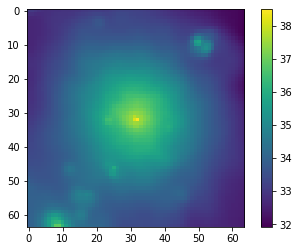

In [5]:
for i in range(101073, 101074):
    flux = make_obs(i)
    # print(flux)
    # flux.convert_to_physical()
    # print(flux)
    # print(flux.comoving)
    # print(flux.cosmo_factor)
    print(np.sum(flux) * (2*2000/64)**2)
    plt.imshow(np.log10(flux))
    plt.colorbar()
    plt.show()